0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0, 'Number of antennas M')

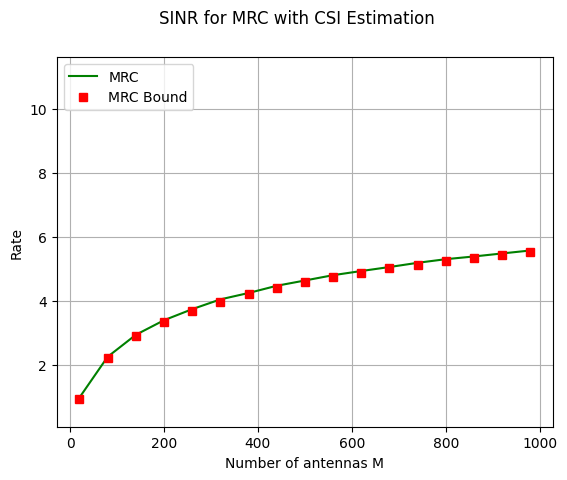

In [ ]:
import numpy as np
import numpy.linalg as nl
import numpy.random as nr
import matplotlib.pyplot as plt
import MIMO

ITER = 2000; # number of iterations
K = 10; # number of users
Mv = np.arange(20,1000,60); # number of BS antennas
Eu_dB = 10;  Eu = 10**(Eu_dB/10); # user energy in linear and log scale
rate_MRC = np.zeros(len(Mv)) ;  # rate of MRC
bound_MRC = np.zeros(len(Mv));  # theoretical bound for MRC
rate_ZF = np.zeros(len(Mv));  #  rate of ZF receiver

beta = MIMO.Dmatrix(K); # Large scaling coeff beta
sqrtD = np.diag(np.sqrt(beta)); # diagonal beta matrix
dftmtx = MIMO.DFTmat(K);  # DFT matrix of size K

for it in range(ITER):
  print(it);
  for mx in range(len(Mv)):
    M = Mv[mx];   # Number of BS antennas for current iteration
    pu = Eu;  # no power scaling
    #pu = Eu/M;   # power scaling
    #pu = Eu/np.sqrt(M); # power scaling
    Pp = K*pu;  # Total Pilot power
    # Generate Massive MIMO channel matrix having small scale fading coefficients
    H = (nr.normal(size=(M,K))+1j*nr.normal(size=(M,K)))/np.sqrt(2);
    G = np.matmul(H,sqrtD); # Channel matrix M*K
    g0 = G[:,0];  # column of user 0 because we want to calculate rate of user 1
    Phi = np.sqrt(1/K)*dftmtx; # Pilot matrix
    # Noise matrix
    N = (nr.normal(size=(M,K))+1j*nr.normal(size=(M,K)))/np.sqrt(2);
    RxBlk = np.sqrt(Pp)*np.matmul(G,Phi) + N; # received signal at Rx
    Ghat = np.sqrt(1/Pp)*np.matmul(RxBlk,MIMO.H(Phi));  # Channel estimation
    g0hat = Ghat[:,0];  # estimation for user 1
    g0 = G[:,0];  # actual channel vector for user 1
    e0 = g0hat - g0;  # channel estimation error for user 1
    nr_MRC = pu*nl.norm(g0)**2; # numerator of SINR when MRC
    nr_bound_MRC = pu*M*beta[0];  # beta[0] when M tends to infinity
    dr_bound_MRC = 1/K + (beta[0]+1/K/pu)/beta[0];  # denominator of SINR expression
    g0norm = g0/nl.norm(g0); # normalized actual channel vector for user 1
    g0hat_norm = g0hat/nl.norm(g0);# normalized estimated channel vector for user 1
    CSIint = np.matmul(MIMO.H(g0norm),e0);  # interference due to channel estimation error
    CSIint = pu*np.abs(CSIint)**2; # Power of interference
    nint = nl.norm(g0hat)**2/nl.norm(g0)**2; # Noise interference power
    dr_MRC = CSIint + nint; # interference power plus noise power
    # denominator for MRC bound noise + channel est error + mu interference
    dr_bound_MRC = dr_bound_MRC + pu*np.sum((beta[0]+1/K/pu)*beta[1:]/beta[0]);
    MUint = np.matmul(MIMO.H(g0hat_norm),G[:,1:]);
    dr_MRC = dr_MRC + pu*nl.norm(MUint)**2; # MU interference + noise power
    rate_MRC[mx] = rate_MRC[mx] + np.log2(1+nr_MRC/dr_MRC); # Capacity when M is a constant value for current loop
    # bound is the capacity when M->inf
    bound_MRC[mx] = bound_MRC[mx] + np.log2(1 + nr_bound_MRC/dr_bound_MRC);

rate_MRC = rate_MRC/ITER;
bound_MRC = bound_MRC/ITER;
plt.plot(Mv, rate_MRC,'g-');
plt.plot(Mv, bound_MRC,'rs');
plt.grid(1,which='both')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.1*y1,2*y2))
plt.legend(["MRC", "MRC Bound"], loc ="upper left");
plt.suptitle('SINR for MRC with CSI Estimation')
plt.ylabel('Rate')
plt.xlabel('Number of antennas M')